### Pleiades Download 
Pléiades 1A/1B are very-high resolution twin satellites offering 0.5m resolution products. The constellation is highly reactive and has been designed for daily revisit anywhere on Earth, with stereo and tri-stereo capacity. This block has a special feature: it is possible to order (and pay for) the data once and then run workflows using this data as often as needed.

In [2]:
import up42

In [3]:
# Authenticate and initialize project.
up42.authenticate(project_id="1234", 
                  project_api_key="uvxw")
project = up42.initialize_project()

2021-03-24 10:10:09,994 - Authentication with UP42 successful!
2021-03-24 10:10:11,098 - Initialized Project(name: Pleiades-Reflectance-Download-example, project_id: 78704e37-348d-4cf0-b1df-6761d218aa0a, description: , createdAt: 2021-03-22T09:41:59.789881Z)


In [4]:
# Construct the workflow.
workflow = project.create_workflow(name="Pleiades-download-example", use_existing=True)
input_tasks = ["oneatlas-pleiades-fullscene"]
workflow.add_workflow_tasks(input_tasks)

2021-03-24 10:10:13,494 - Getting existing workflows in project ...
2021-03-24 10:10:14,651 - Got 1 workflows for project 78704e37-348d-4cf0-b1df-6761d218aa0a.
100%|██████████| 1/1 [00:01<00:00,  1.28s/it]
2021-03-24 10:10:15,967 - Using existing workflow: Pleiades-download-example - 5c1fbe99-c528-41fd-9e99-81aa8f16f3ec
2021-03-24 10:10:20,512 - Added tasks to workflow: [{'name': 'oneatlas-pleiades-fullscene:1', 'parentName': None, 'blockId': 'defb134b-ca00-4e16-afa0-639c6dc0c5fe'}]


In [9]:
# Define the aoi.
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
              [
                13.362627,
                52.489731
              ],
              [
                13.370466,
                52.489731
              ],
              [
                13.370466,
                52.493719
              ],
              [
                13.362627,
                52.493719
              ],
              [
                13.362627,
                52.489731
              ]
            ]
          ]
      }
    }
  ]
}


In [25]:
# We use catalogue search to have a quicklook for plotting. 
catalog = up42.initialize_catalog()
search_paramaters = catalog.construct_parameters(geometry=aoi, 
                                                 start_date="2019-01-01",
                                                 end_date="2020-12-31",
                                                 sensors=["pleiades"],
                                                 max_cloudcover=5,
                                                 sortby="acquisitionDate",
                                                 ascending=False,
                                                 limit=1)
search_paramaters["query"]["deliveryTime"] = {"in": ["MINUTES"]} 
search_results = catalog.search(search_paramaters)

2021-03-24 10:35:06,346 - Searching catalog with search_parameters: {'datetime': '2019-01-01T00:00:00Z/2020-12-31T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((13.362627, 52.489731), (13.370466, 52.489731), (13.370466, 52.493719), (13.362627, 52.493719), (13.362627, 52.489731)),)}, 'limit': 1, 'query': {'dataBlock': {'in': ['oneatlas-pleiades-fullscene', 'oneatlas-pleiades-aoiclipped']}, 'cloudCoverage': {'lte': 5}, 'deliveryTime': {'in': ['MINUTES']}}, 'sortby': [{'field': 'properties.acquisitionDate', 'direction': 'desc'}]}
2021-03-24 10:35:07,088 - 1 results returned.


In [26]:
search_paramaters

{'datetime': '2019-01-01T00:00:00Z/2020-12-31T23:59:59Z',
 'intersects': {'type': 'Polygon',
  'coordinates': (((13.362627, 52.489731),
    (13.370466, 52.489731),
    (13.370466, 52.493719),
    (13.362627, 52.493719),
    (13.362627, 52.489731)),)},
 'limit': 1,
 'query': {'dataBlock': {'in': ['oneatlas-pleiades-fullscene',
    'oneatlas-pleiades-aoiclipped']},
  'cloudCoverage': {'lte': 5},
  'deliveryTime': {'in': ['MINUTES']}},
 'sortby': [{'field': 'properties.acquisitionDate', 'direction': 'desc'}]}

In [27]:
search_results

,geometry,id,acquisitionDate,constellation,collection,providerName,blockNames,cloudCoverage,up42:usageType,providerProperties,sceneId,resolution,deliveryTime,producer
0,"POLYGON ((13.21202 52.58004, 13.21264 52.45083...",fa02819c-d04a-462a-9478-f1d8b9bd3e90,2020-05-06T10:19:18Z,PHR,PHR,oneatlas,"[oneatlas-pleiades-display, oneatlas-pleiades-...",2.95,"[DATA, ANALYTICS]","{'commercialReference': 'SO20033509', 'qualifi...",DS_PHR1A_202005061019188_FR1_PX_E013N52_0513_0...,0.5,MINUTES,Airbus


2021-03-24 10:35:20,347 - Getting quicklooks from provider oneatlas for image_ids: ['fa02819c-d04a-462a-9478-f1d8b9bd3e90']
2021-03-24 10:35:20,349 - Download directory: /Users/wilhelmina.nekoto/repos/up42-py/examples/data-block-examples/project_78704e37-348d-4cf0-b1df-6761d218aa0a/catalog
100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


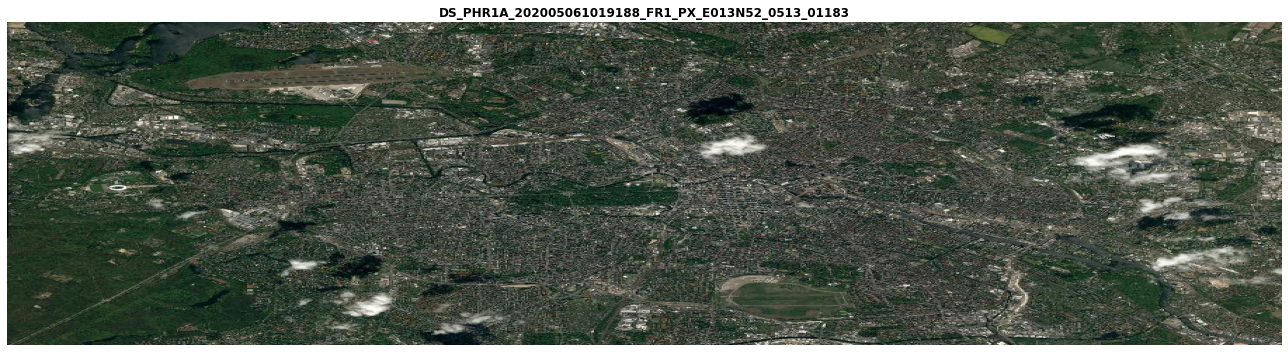

In [28]:
# Download & Visualise quicklooks.
catalog.download_quicklooks(image_ids=search_results.id.to_list(), sensor="pleiades")
# display(search_results.head())
catalog.plot_quicklooks(figsize=(18,5), titles=search_results.sceneId.to_list())

# Select least cloud scene for further workflow.
aoi["sceneId"] = search_results.sceneId.to_list()[0]

### Workflow construction and Job

In [29]:
input_parameters = workflow.construct_parameters(geometry=aoi, 
                                                 geometry_operation="bbox", 
                                                 scene_ids=[aoi["sceneId"]])

In [30]:
aoi

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[13.362627, 52.489731],
      [13.370466, 52.489731],
      [13.370466, 52.493719],
      [13.362627, 52.493719],
      [13.362627, 52.489731]]]}}],
 'sceneId': 'DS_PHR1A_202005061019188_FR1_PX_E013N52_0513_01183'}

In [31]:
# Estimate price.
workflow.estimate_job(input_parameters)

2021-03-24 10:35:48,196 - Estimated: 241-253 Credits, Duration: 0-0 min.


{'oneatlas-pleiades-fullscene:1': {'blockConsumption': {'resources': {'unit': 'SQUARE_KM',
    'min': 0.24,
    'max': 0.252},
   'credit': {'min': 240, 'max': 252}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}}}

In [32]:
# Run a test job to query data availability and check the configuration.
test_job = workflow.test_job(input_parameters, track_status=True)

2021-03-24 10:35:52,624 - +++++++++++++++++++++++++++++++++
2021-03-24 10:35:52,625 - Running this job as Test Query...
2021-03-24 10:35:52,625 - +++++++++++++++++++++++++++++++++
2021-03-24 10:35:52,626 - Selected input_parameters: {'oneatlas-pleiades-fullscene:1': {'limit': 1, 'max_cloud_cover': 100, 'ids': ['DS_PHR1A_202005061019188_FR1_PX_E013N52_0513_01183'], 'bbox': [13.362627, 52.489731, 13.370466, 52.493719]}, 'config': {'mode': 'DRY_RUN'}}
2021-03-24 10:35:54,383 - Created and running new job: 002d0c97-9cbf-439c-8091-ba1d5f7b88fc.
2021-03-24 10:35:54,943 - Tracking job status continuously, reporting every 30 seconds...
2021-03-24 10:36:17,757 - Job finished successfully! - 002d0c97-9cbf-439c-8091-ba1d5f7b88fc


In [33]:
# Run the actual live job.
job = workflow.run_job(input_parameters, track_status=True)

2021-03-24 10:37:39,766 - Selected input_parameters: {'oneatlas-pleiades-fullscene:1': {'limit': 1, 'max_cloud_cover': 100, 'ids': ['DS_PHR1A_202005061019188_FR1_PX_E013N52_0513_01183'], 'bbox': [13.362627, 52.489731, 13.370466, 52.493719]}}
2021-03-24 10:37:45,038 - Created and running new job: 041e7c95-333e-4684-a170-70b753f9f346.
2021-03-24 10:37:45,621 - Tracking job status continuously, reporting every 30 seconds...
2021-03-24 10:38:19,485 - Job is RUNNING! - 041e7c95-333e-4684-a170-70b753f9f346
2021-03-24 10:38:52,936 - Job is RUNNING! - 041e7c95-333e-4684-a170-70b753f9f346
2021-03-24 10:39:26,298 - Job is RUNNING! - 041e7c95-333e-4684-a170-70b753f9f346
2021-03-24 10:39:59,807 - Job is RUNNING! - 041e7c95-333e-4684-a170-70b753f9f346
2021-03-24 10:40:33,178 - Job is RUNNING! - 041e7c95-333e-4684-a170-70b753f9f346
2021-03-24 10:41:06,487 - Job is RUNNING! - 041e7c95-333e-4684-a170-70b753f9f346
2021-03-24 10:41:39,543 - Job is RUNNING! - 041e7c95-333e-4684-a170-70b753f9f346
2021-03-

In [34]:
# Downlod Results.
job.download_results()

2021-03-24 11:06:43,203 - Downloading results of job 041e7c95-333e-4684-a170-70b753f9f346
2021-03-24 11:06:43,204 - Download directory: /Users/wilhelmina.nekoto/repos/up42-py/examples/data-block-examples/project_78704e37-348d-4cf0-b1df-6761d218aa0a/job_041e7c95-333e-4684-a170-70b753f9f346
1973it [00:00, 239352.17it/s]
2021-03-24 11:06:45,229 - Download successful of 54 files to output_directory '/Users/wilhelmina.nekoto/repos/up42-py/examples/data-block-examples/project_78704e37-348d-4cf0-b1df-6761d218aa0a/job_041e7c95-333e-4684-a170-70b753f9f346': ['usage.json', 'data.json', 'bef0a87b-bf03-498f-bdab-71e2c332670b', 'VOL_PHR.XML', 'INDEX.HTM', 'LIBRARY', 'IMG_PHR1A_MS_001', 'IMG_PHR1A_P_002', 'LOGO.JPG', 'VOL_STYL.XSL', 'PREVIEW_PHR1A_MS_202005061019188_ORT_fe986d5f-2a62-441e-c4fa-134fbec88c46-001.KMZ', 'LUT_PHR1A_MS_202005061019188_ORT_fe986d5f-2a62-441e-c4fa-134fbec88c46-001.XML', 'IMG_PHR1A_MS_202005061019188_ORT_fe986d5f-2a62-441e-c4fa-134fbec88c46-001_R1C1.J2W', 'INDEX.HTM', 'LIBRA

['/Users/wilhelmina.nekoto/repos/up42-py/examples/data-block-examples/project_78704e37-348d-4cf0-b1df-6761d218aa0a/job_041e7c95-333e-4684-a170-70b753f9f346/usage.json',
 '/Users/wilhelmina.nekoto/repos/up42-py/examples/data-block-examples/project_78704e37-348d-4cf0-b1df-6761d218aa0a/job_041e7c95-333e-4684-a170-70b753f9f346/data.json',
 '/Users/wilhelmina.nekoto/repos/up42-py/examples/data-block-examples/project_78704e37-348d-4cf0-b1df-6761d218aa0a/job_041e7c95-333e-4684-a170-70b753f9f346/DS_PHR1A_202005061019188_FR1_PX_E013N52_0513_01183/bef0a87b-bf03-498f-bdab-71e2c332670b',
 '/Users/wilhelmina.nekoto/repos/up42-py/examples/data-block-examples/project_78704e37-348d-4cf0-b1df-6761d218aa0a/job_041e7c95-333e-4684-a170-70b753f9f346/DS_PHR1A_202005061019188_FR1_PX_E013N52_0513_01183/bef0a87b-bf03-498f-bdab-71e2c332670b/VOL_PHR.XML',
 '/Users/wilhelmina.nekoto/repos/up42-py/examples/data-block-examples/project_78704e37-348d-4cf0-b1df-6761d218aa0a/job_041e7c95-333e-4684-a170-70b753f9f346/DS_